## 0. Carregamento das bibliotecas

In [1]:
# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# Selecao de caracteristicas e encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# balanceamento
from imblearn.under_sampling import RandomUnderSampler

# Importar metrica
from sklearn.feature_selection import chi2

from scipy.stats import chi2_contingency

## 1. Carregamento dos dados

In [2]:
df = pd.read_csv("covid_11_marco_limpo.csv", sep=';')

## 2.  *Feature Encoding*

Como modelos de *machine learning* performam algebra linear em matrizes, precisamos que todas as variáveis estejam como valores numericos. O processo de conversão de variaveis categoricas em numéricas é chamado de *Encoding*. Existem algumas abordagens para converter os dados categóricos em numéricos, para que o modelo possa entendê-los. Veremos os dois métodos: **Label encoding** e **One-Hot encoding**.

- Label Encoding: Recomendado quando lidamos com variáveis categóricas ordinais: Consiste em *designar um valor inteiro* (0, 1, 2, ...) oara cada valor unico da coluna.
- One-hot encoding: Consiste em *criar uma nova coluna* para cada valor único de uma coluna existente.

Material complementar:
- [Um guia (simples) de como tratar variáveis categóricas em Machine Learning](https://medium.com/@nelson.ewert.oliveira/um-guia-simples-de-como-tratar-vari%C3%A1veis-categ%C3%B3ricas-em-machine-learning-b791a00da805)
- [One-Hot Encoding vs. Label Encoding using Scikit-Learn](https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/)
- [Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html)

Para nosso contexto, vamos utilizar o **label encoding**.


Antes de transformar em labels, vamos ter certeza que a ordem das idades está correta. Vamos fazer isso transformando a coluna em 'Categorical' e afirmando a ordem.

In [3]:
df['FAIXAETARIA'].value_counts()

30 a 39      125074
20 a 29      109275
40 a 49      101034
50 a 59       83274
60 a 69       54050
70 a 79       26580
15 a 19       23934
80 e mais     13480
10 a 14       10642
05 a 09        8581
01 a 04        7303
<1             2621
Name: FAIXAETARIA, dtype: int64

In [4]:
df['FAIXAETARIA'] = pd.Categorical(df['FAIXAETARIA'], 
                      categories=["<1","01 a 04","05 a 09","10 a 14", "15 a 19", "20 a 29", 
                                  '30 a 39', '40 a 49', '50 a 59', '60 a 69', '70 a 79', '80 e mais'],
                      ordered=True)

In [5]:
df = df.apply(LabelEncoder().fit_transform)

df.head()

,SEXO,FAIXAETARIA,EVOLUCAO,FEBRE,TOSSE,GARGANTA,DISPNEIA,GESTANTE,RACA_COR,CARDIOPATIA,...,DOENCA_RESPIRATORIA,DOENCA_NEUROLOGICA,PROBLEMA_RENAL,OBESIDADE,IMUNODEFICIENCIA,IMUNOSSUPRESSAO,HEPATITE,DOENCA_CROMOSSOMICA,DOENCA_HEMATOLOGICA,PUERPERA
0,0,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,7,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,7,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,6,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Seleção / Redução de características

Uma vez que temos as nossas *features* prontas para uso, talvez podemos achar que o número de *features* disponíveis é muito grande para treinar modelos de machine learning em um tempo razoável. Isto também impacta na complexidade dos modelos. Existem algumas opções disponíveis para redução de características e seleção de características (*feature reduction* e *feature selection*).

 - Importância/relevância de características (*Feature Importance/Relevance*):
     - Métodos de filtragem (*Filter Methods*): Métodos de filtragem de tipo selecionam características baseadas apenas em méticas gerais, tipo correlação desta variável com a variável preditora. Métodos de filtragem suprimem as variáveis menos "interessantes". Esse método é particularmente efetivo em tempo de computação e traz robustêz contra *overfitting*.
     - Métodos de invólucro (*Wrapper methods*): São utilizados para avaliar subconjuntos de variáveis que possibilitam (diferentemente dos metodos de filtragem) detectar possíveis interações entre variáveis. As duas principais desvantagens desses métodos são: (1) aumento do risco de *overfitting* quando o número de amostras é pequeno ou insuficiente. (2) Aumento significativo do tempo de conputação quando o número de variáveis é grande.
     - Métodos imbutidos (*Embedded Methods*): Tentam combinar a vantagem dos dois métodos anteriores. Um algoritmo de aprendizagem toma vantagem do seu próprio processo de seleção de variáveis e executa a seleção de caraterísticas e classificação simultâneamente.
     
#### Correlação entre as características

Os coeficientes de correlação é a medida do quanto duas variáveis aleatóricas mudam juntas. O que a correlação procura entender é como uma variável se comporta em um cenário onde outra está variando, visando identificar se existe alguma relação entre a variabilidade de ambas. Embora não implique em causalidade, o coeficiente de correlação exprime em números essa relação, ou seja, quantifica a relação entre as variáveis. Em suma, **é o quanto uma variável está ligada a outra.**

O coeficiente de correlação de Pearson (r), também chamado de correlação linear ou r de Pearson, é um grau de relação entre duas variáveis quantitativas e exprime o grau de correlação através de valores situados entre -1 e 1.

Quando  o coeficiente de correlação se aproxima de 1, nota-se um aumento no valor de uma variável quando a outra também aumenta, ou seja, há uma relação linear positiva. Quando o coeficiente se aproxima de -1, também é possível dizer que as variáveis são correlacionadas, mas nesse caso quando o valor de uma variável aumenta o da outra diminui. Isso é o que é chamado de correlação negativa ou inversa.

Características podem estar não-correlacionadas ou correlacionadas com a característica que estamos predizer.

Para critério de inclusão e de importância de características, vamos observar apenas as variáveis que possuem um coeficiente >= +- 0.1 com relação a nossa variável predita (ÓBITO).  
     

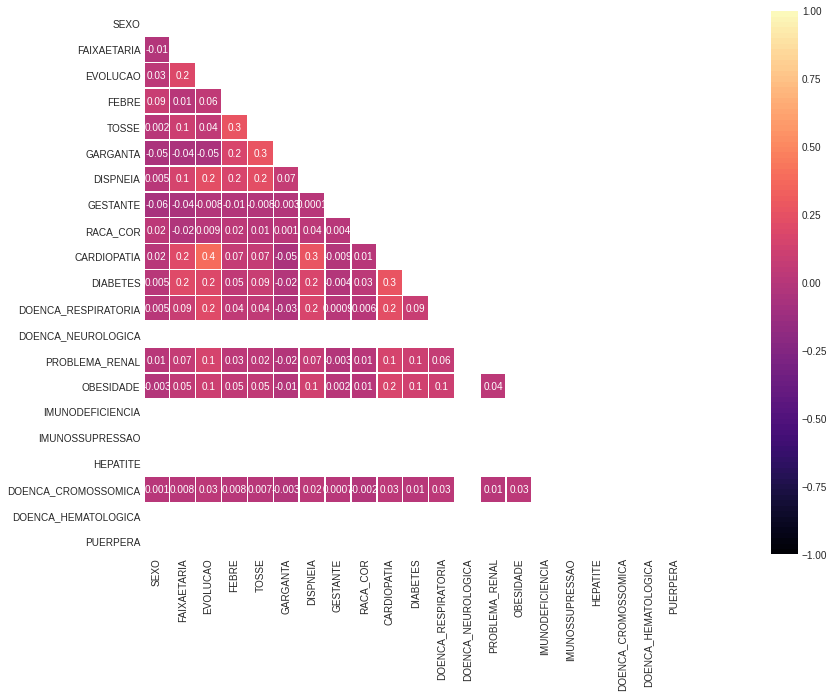

In [6]:
# matriz de correlacao
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,10)) 

# gerando mascara para a diagonal superior ficar vazia
mask = np.zeros_like(df.corr(method='pearson'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(method='pearson'), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("magma", 100), 
            mask=mask, 
            annot=True,
            fmt='.1g',
            linewidths=.5);

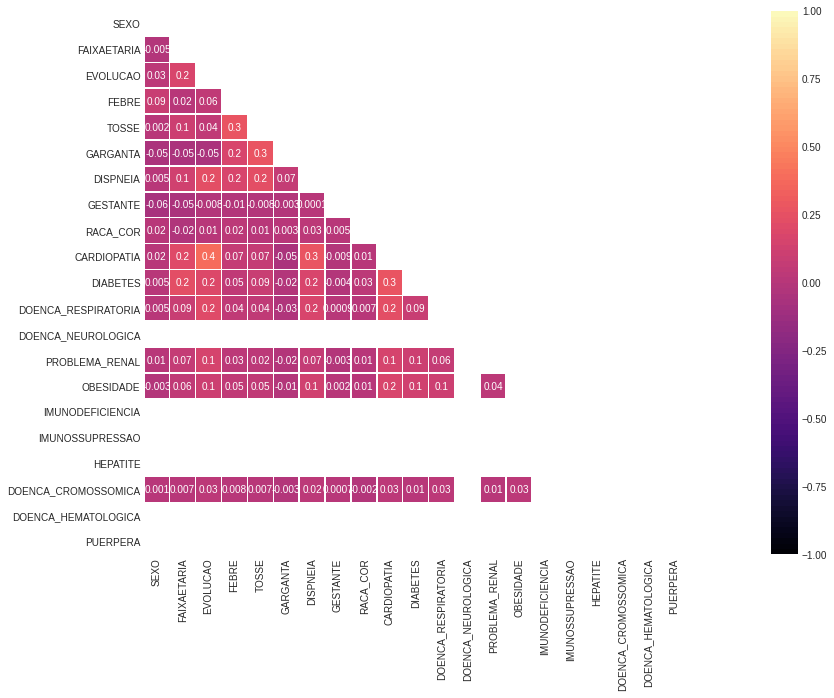

In [7]:
# matriz de correlacao
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,10)) 

# gerando mascara para a diagonal superior ficar vazia
mask = np.zeros_like(df.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(method='spearman'), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("magma", 100), 
            mask=mask, 
            annot=True,
            fmt='.1g',
            linewidths=.5);

### Chi Square

Chi-Quadrado (ou também chamado de Chi-Squared).

Chi Quadrado mede a relação de dependência entre duas variáveis categóricas, verificando como os valores esperados desviam dos valores observados.

Quando temos um alto valor de Chi-quadrado (nosso p-value será baixo), significa que temos evidência estatística para inferir que os valores observados e esperados não são os mesmos, portanto possuem dependência entre si.

Quanto mais alto o Chi-quadrado, maior a dependência entre as variáveis.

Utilizaremos o nosso nível de significancia (alpha) em 0.05. A nossa hipótese nula (h0) é de que não há diferença significativa entre os valores de cada variável dicotômica, em relação ao paciente vir a óbito ou não. Caso o valor de p seja maior que 0.5, não há evidência de difernça significativa, e então a variável não difere entre si e não explica a chance de óbito.

Exemplo: Se o p-value for maior que 0.05 na variável sexo. Significa que não há diferença significativa entre homens e mulheres que vem a óbito por covid-19.

In [8]:
X = df.drop(['EVOLUCAO'], axis=1)
y = df['EVOLUCAO']

In [9]:
pd.set_option('display.float_format','{:.15f}'.format)
from collections import defaultdict
chi_square = defaultdict(list)

for col in df.drop(['EVOLUCAO'], axis=1).columns:
    contigency = pd.crosstab(df[col], df['EVOLUCAO']) 
    c, p, dof, expected = chi2_contingency(contigency) 
    chi_square['Coluna'].append(col)
    chi_square['Chi Quadrado'].append(c)
    chi_square['P valor'].append(p)
    chi_square['Graus de liberdade'].append(dof)

# criando data frame a partir do dicionario com os dados
chi_df = pd.DataFrame.from_dict(chi_square)
# criar variavel para testar os menores que 0.05
chi_df["Significante"] = chi_df.apply(lambda row: row["P valor"] < 0.05, axis=1)


In [10]:
chi_df.sort_values(by='P valor')

,Coluna,Chi Quadrado,P valor,Graus de liberdade,Significante
9,DIABETES,22044.380829165427713,0.000000000000000,1,True
1,FAIXAETARIA,46804.040732764144195,0.000000000000000,11,True
2,FEBRE,1948.650323332470634,0.000000000000000,1,True
4,GARGANTA,1426.508618562365427,0.000000000000000,1,True
5,DISPNEIA,32018.129926318641083,0.000000000000000,1,True
13,OBESIDADE,8016.737129087562607,0.000000000000000,1,True
8,CARDIOPATIA,87704.787998091444024,0.000000000000000,1,True
12,PROBLEMA_RENAL,11085.045014475546850,0.000000000000000,1,True
10,DOENCA_RESPIRATORIA,25329.241487803064956,0.000000000000000,1,True
3,TOSSE,1113.934197880533702,0.000000000000000,1,True


In [11]:
chi_df[chi_df["P valor"] < 0.05]

,Coluna,Chi Quadrado,P valor,Graus de liberdade,Significante
0,SEXO,362.529672317077939,0.000000000000000,1,True
1,FAIXAETARIA,46804.040732764144195,0.000000000000000,11,True
2,FEBRE,1948.650323332470634,0.000000000000000,1,True
3,TOSSE,1113.934197880533702,0.000000000000000,1,True
4,GARGANTA,1426.508618562365427,0.000000000000000,1,True
5,DISPNEIA,32018.129926318641083,0.000000000000000,1,True
6,GESTANTE,31.825753482148798,0.000000016864178,1,True
7,RACA_COR,92.796482242243741,0.000000000000000,4,True
8,CARDIOPATIA,87704.787998091444024,0.000000000000000,1,True
9,DIABETES,22044.380829165427713,0.000000000000000,1,True


In [12]:
# removendo os valores com pvalue maiores que 0.05
df1 = df[chi_df[chi_df["P valor"] < 0.05]['Coluna']]

In [13]:
df1 = pd.concat([df1, df['EVOLUCAO']], axis=1)

In [14]:
df1.columns

Index(['SEXO', 'FAIXAETARIA', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA',
       'GESTANTE', 'RACA_COR', 'CARDIOPATIA', 'DIABETES',
       'DOENCA_RESPIRATORIA', 'PROBLEMA_RENAL', 'OBESIDADE',
       'DOENCA_CROMOSSOMICA', 'EVOLUCAO'],
      dtype='object')

In [15]:
df1

,SEXO,FAIXAETARIA,FEBRE,TOSSE,GARGANTA,DISPNEIA,GESTANTE,RACA_COR,CARDIOPATIA,DIABETES,DOENCA_RESPIRATORIA,PROBLEMA_RENAL,OBESIDADE,DOENCA_CROMOSSOMICA,EVOLUCAO
0,0,6,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,7,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,7,1,0,0,1,0,1,1,0,0,0,0,0,0
4,1,6,1,0,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565843,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0
565844,0,10,0,0,0,0,0,1,0,0,0,0,0,0,0
565845,1,6,0,0,0,0,0,1,0,0,0,0,0,0,0
565846,0,2,0,0,0,1,0,1,0,0,1,0,0,0,0


# Conclusão
Após as transformações e preprocessamento, vamos armazenar o data frame para construção do modelo posterior.

In [16]:
df1.to_csv("covid_11_marco_pre_process.csv", sep=';', index=False)

## [EXTRA] 4. Feature Importance Florestas aleatórias
Florestas aleatórias consistem em um conjunto de árvores de decisão. Cada nó na árvore de decisão é uma condição de uma variável única, que objetiva dividir o conjunto de dados em dois de forma que valores de resposta semelhantes estejam no mesmo conjunto. A medida com base na qual a condição ótima (máximo local) é escolhido é chamado de *impurity*. Ao treinar uma árvore, pode-se calcular quanto cada recurso diminui a impureza ponderada em uma árvore. Para uma floresta, a diminuição da impureza de cada característica pode ser calculada e as características são classificadas de acordo com esta medida. Esta é a medida classificação de *feature importance* exposta nas implementações da Random Forest do sklearn, e existe dentro de `feature_importances_`.

Vamos utilizar de uma floresta aleatória para entender a importância das características do nosso conjunto de dados.

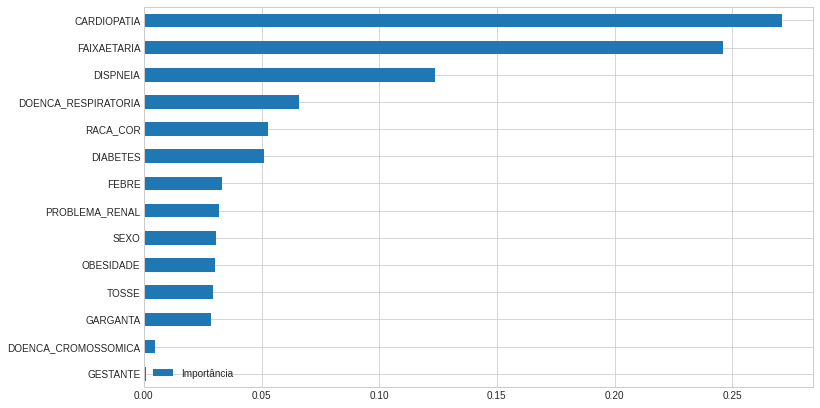

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df1.drop('EVOLUCAO', axis=1), df1['EVOLUCAO'])

plt.style.use('seaborn-whitegrid')
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=df1.drop('EVOLUCAO', axis=1).columns, columns=["Importância"])
importance.sort_values(by='Importância', ascending=True).plot(kind='barh', figsize=(12,len(importance)/2));